# Silver EDA

This notebook is dedicated towards conducting EDA that will determine the steps necessary to transform the raw dataset into a silver state. Recall this project uses a psuedo [medallion](https://www.databricks.com/glossary/medallion-architecture) architecture where the silver layer data is transformed into a state ready for analysis/feature engineering. Check docs\etl.drawio.svg for more details. This analysis focuses on what transformations can be done to reduce dataset size so that the silver layer is ready for analysis/feature engineering on local compute. 

NOTE: The dataset is already relatively curated for modeling due to it being a competition dataset, so extreme data munging/cleaning is not necessary. 

In [66]:
import sys 
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from leash_bio_ai.utils.conf import train_dir

train_df = pl.scan_parquet(source=train_dir)

In [67]:
train_df.head(n=5).collect()

id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
i64,str,str,str,str,str,i64
0,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.Br.NCC1CCCN1c1cccnn1""","""C#CCOc1ccc(CNc2nc(NCC3CCCN3c3c…","""BRD4""",0
1,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.Br.NCC1CCCN1c1cccnn1""","""C#CCOc1ccc(CNc2nc(NCC3CCCN3c3c…","""HSA""",0
2,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.Br.NCC1CCCN1c1cccnn1""","""C#CCOc1ccc(CNc2nc(NCC3CCCN3c3c…","""sEH""",0
3,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.NCc1cccc(Br)n1""","""C#CCOc1ccc(CNc2nc(NCc3cccc(Br)…","""BRD4""",0
4,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.NCc1cccc(Br)n1""","""C#CCOc1ccc(CNc2nc(NCc3cccc(Br)…","""HSA""",0


### Dataset Size

The primary obstacle of this project is dataset size given the utilization of local computing resources. Developing the silver layer of data will mainly involve dataset size reduction to enable analysis/feature engineering that will then lead into modeling efforts. Note the following opportunities for dataset size reduction:
1. Class Imbalance - binds boolean column
2. Column Value Duplication - molecule_smiles column encapsulates the same information that buildingblock1_smiles, buildingblock2_smiles, and buildingblock3_smiles have, thus much information in the dataset is redundant and duplicated
3. Protein Name Data Type - protein_name takes on 3 distinct string values, this could be converted to an 8-bit integer for better memory efficiency
4. Binds Data Type - polars reads the binary binds column as a 64-bit integer, this could be converted to an 8-bit integer for better memory efficiency

#### Class Imbalance

In [68]:
n_pos = (train_df
         .filter(pl.col("binds")==1)
         .select(pl.count("id"))
         .collect(streaming=True)
         .item())

n_neg = (train_df
         .filter(pl.col("binds")==0)
         .select(pl.count("id"))
         .collect(streaming=True)
         .item())

n_tot = n_pos + n_neg

pct_pos = round(100 * n_pos/n_tot, 4)

print(f"Positive Protein Bonds Records: {n_pos}")
print(f"Negative Protein Bonds Records: {n_neg}")
print(f"Percent of Total Records that are Positive: {pct_pos}%")

Positive Protein Bonds Records: 1589906
Negative Protein Bonds Records: 293656924
Percent of Total Records that are Positive: 0.5385%


Less than 1% of the training dataset belongs to the positive binds class, making this dataset highly imbalanced. When creating the silver layer downsampling can be performed to reduce dataset size and make analysis, feature engineering, and modeling more feasible on local compute with less data. 

Almost the entirety of important molecule information is contained in the "molecule_smiles" column. The more unique molecule smiles that appear for the negative class the more data we likely need to keep for any future model to generalize well to unseen molecule_smiles data. Below we take the first 200,000 negative class rows in the train set and assess how many of the 200,000 observed molecule_smiles values are unique. A higher level of uniqueness will motivate the belief that uniqueness is common in the data and drive a decision to retain more negative class samples so a future model can see as many molecule_smiles as possible.  

In [69]:
top_n = (train_df
         .filter(pl.col("binds")==0)
         .select("molecule_smiles")
         .head(n=200000)
         .collect(streaming=True)
         .n_unique())

In [70]:
print(f"{top_n} of 200,000 molecule_smiles sampled are unique.")

66814 of 200,000 molecule_smiles sampled are unique.


About 1/3 of the sampled molecule_smiles are unique. This is a relatively high degree of uniqueness but also a fair amount of repetitiveness. The amount of data we can train a model on locally will be limited, to try and still get any future model familiar with different unique molecule_smiles values we will downsample the data but still keep ~2x as many negative samples as positive samples. 

### Size Reduction Analysis

Below the polars `estimated_size` method is used to compare the size of a sample 10,000 row baseline dataset with all columns taken from the training data against a dataset of the same 10,000 rows in it but has had a size reduction technique utilized in it. Graphs are then displayed showing how the size in gigabytes for each dataset differs as we approach the true number of rows in the training data. Note that the y-axis are gigabytes so even a slim visual difference will resemble large memory savings.  

In [71]:
baseline_df = train_df.head(n=10000).collect()
baseline_gb = baseline_df.estimated_size("gb")

data_step = np.arange(start=1,stop=n_tot,step=10000)

##### Column Value Duplication

The baseline dataset is compared to a dataset that drops the "buildingblock1_smiles", "buildingblock2_smiles", and "buildingblock3_smiles" columns due to that information being replicated in the "molecule_smiles" column. Reference the competition [column descriptions](https://www.kaggle.com/competitions/leash-BELKA/data) for more details. 

In [72]:
col_reduce_df = (train_df
                 .select("id", "molecule_smiles", "protein_name", "binds")
                 .head(n=10000)
                 .collect())
col_reduce_gb = col_reduce_df.estimated_size("gb")

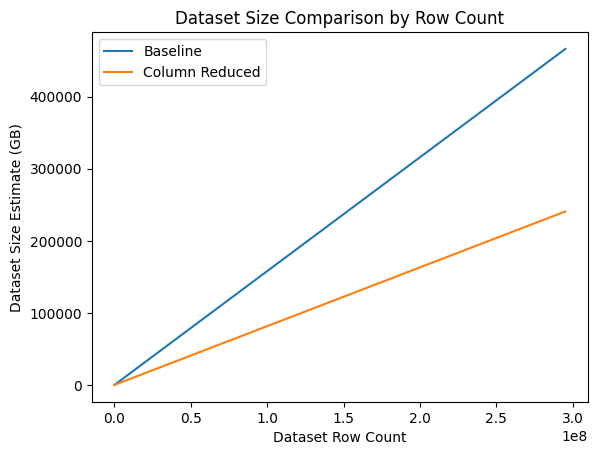

In [73]:
baseline_gb_l = baseline_gb * data_step
col_reduce_gb_l = col_reduce_gb * data_step

plt.plot(data_step, baseline_gb_l, label='Baseline')
plt.plot(data_step, col_reduce_gb_l, label='Column Reduced')

plt.xlabel("Dataset Row Count")
plt.ylabel("Dataset Size Estimate (GB)")
plt.title("Dataset Size Comparison by Row Count")

plt.legend()


Text(0.5, 1.0, 'Size Reduction by Row Count')

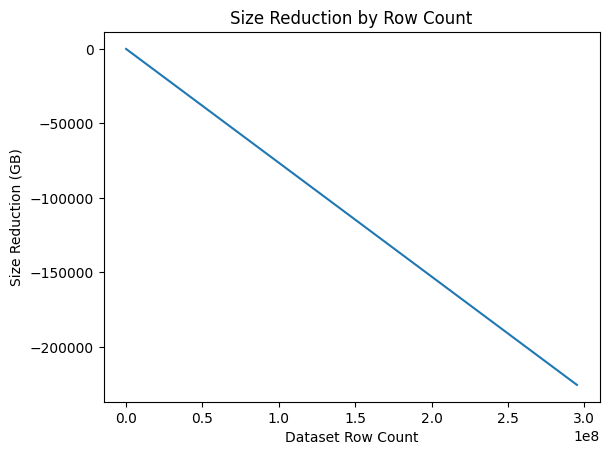

In [74]:
plt.plot(data_step, col_reduce_gb_l - baseline_gb_l, label='Baseline')

plt.xlabel("Dataset Row Count")
plt.ylabel('Size Reduction (GB)')
plt.title("Size Reduction by Row Count")

There is a massive reduction in dataset size by eliminating the buildingblock smiles columns and only retaining the molecule_smiles column instead. We don't lose any information by excluding these columns but we gain a massive reduction in dataset size which is crucial for this projects execution on local compute. 

##### Protein Name Integer Conversion

The protein_name column contains 3 unique string values "BRD4", "HSA", "sEH". These can be encoded into 8-bit integers to reduce dataset size.  

In [75]:
mapper = {"BRD4":0, "HSA":1, "sEH":2}

str_reduce_df = (train_df
                 .head(n=10000)
                 .collect()
                 .with_columns(protein_int=pl.col("protein_name").replace(mapper))
                 .select("id",
                         "buildingblock1_smiles",
                         "buildingblock2_smiles",
                         "buildingblock3_smiles",
                         "molecule_smiles",
                         pl.col("protein_int").cast(pl.Int8),
                         "binds"))
str_reduce_gb = str_reduce_df.estimated_size("gb")
str_reduce_gb_l = str_reduce_gb * data_step

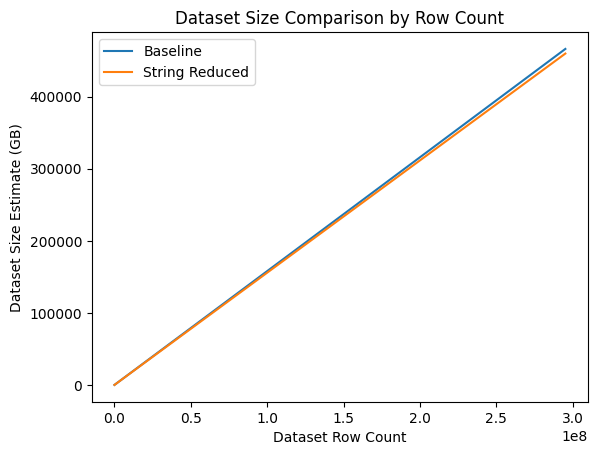

In [76]:
plt.plot(data_step, baseline_gb_l, label='Baseline')
plt.plot(data_step, str_reduce_gb_l, label='String Reduced')

plt.xlabel("Dataset Row Count")
plt.ylabel("Dataset Size Estimate (GB)")
plt.title("Dataset Size Comparison by Row Count")

plt.legend()

Text(0.5, 1.0, 'Size Reduction by Row Count')

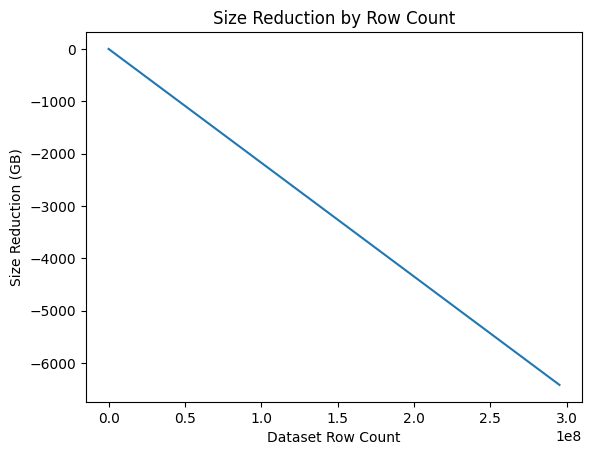

In [77]:
plt.plot(data_step, str_reduce_gb_l - baseline_gb_l, label='Baseline')

plt.xlabel("Dataset Row Count")
plt.ylabel('Size Reduction (GB)')
plt.title("Size Reduction by Row Count")

##### Binds Integer Type

Polars pulls in the binary binds column as a 64-bit integer, casting this as an 8-bit integer should result in lower memory strain on local compute. 

In [78]:
bit_reduce_df = (train_df.select("id", 
                                 "buildingblock1_smiles", 
                                 "buildingblock2_smiles", 
                                 "buildingblock3_smiles", 
                                 "molecule_smiles", 
                                 "protein_name", 
                                 pl.col("binds").cast(pl.Int8))
                 .head(n=10000)
                 .collect())
bit_reduce_gb = bit_reduce_df.estimated_size("gb")
bit_reduce_gb_l = bit_reduce_gb * data_step

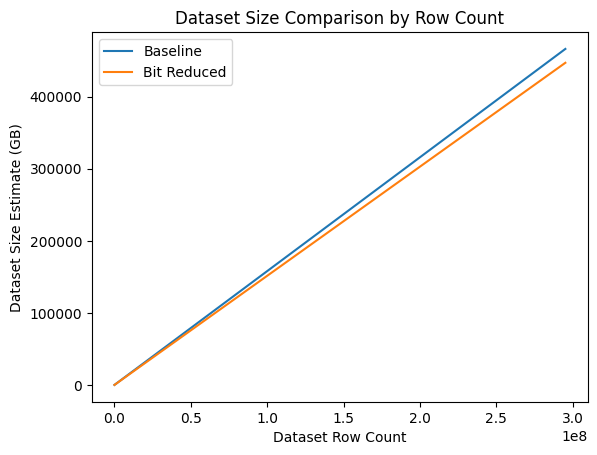

In [79]:
plt.plot(data_step, baseline_gb_l, label='Baseline')
plt.plot(data_step, bit_reduce_gb_l, label='Bit Reduced')

plt.xlabel("Dataset Row Count")
plt.ylabel("Dataset Size Estimate (GB)")
plt.title("Dataset Size Comparison by Row Count")

plt.legend()

Text(0.5, 1.0, 'Size Reduction by Row Count')

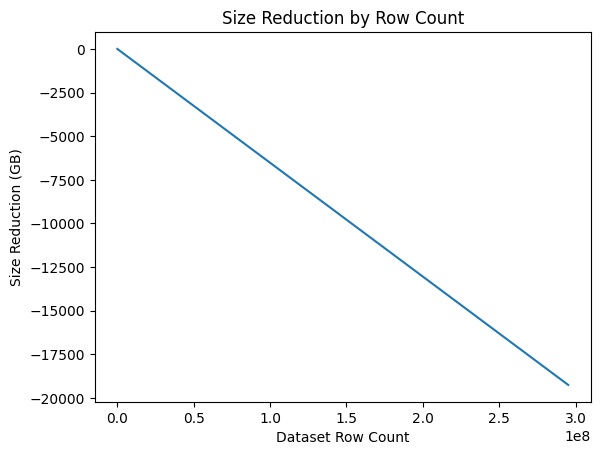

In [80]:
plt.plot(data_step, bit_reduce_gb_l - baseline_gb_l, label='Baseline')

plt.xlabel("Dataset Row Count")
plt.ylabel('Size Reduction (GB)')
plt.title("Size Reduction by Row Count")

### Silver Layer Steps

This EDA verified that steps we can take in making with silver layer will in fact reduce dataset size and be beneficial for this use case. The competition dataset itself is already curated for modeling so the main focus of creating the silver layer was trimming the data down to be workable. Here are the steps that we'll undergo to generate the silver layer"
1. Remove rows with missing data.
2. Remove "buildingblock1_smiles", "buildingblock2_smiles", and "buildingblock3_smiles" while retaining "molecule_smiles" to reduce duplicated information in the dataset.
3. Encode "protein_name" into an integer column and cast as an 8-bit integer when processing the dataset.
4. Cast "binds" as an 8-bit integer when processing the dataset. 